# CLIP from Stable Diffusion Pipeline

In [1]:
from PIL import Image
import torch
import numpy as np
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

In [2]:
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")

In [3]:
from utils import data
prompt = list(data.descriptions[:, 0])
#prompt = list(data.sentences[:, 0])
prompt

['a blue truck', 'a blue plain', 'a orange truck', 'a orange plain']

In [4]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
#text_input

In [5]:
with torch.no_grad():
    output = text_encoder(text_input.input_ids)
#output

In [6]:
pooled = output.pooler_output
pooled.shape

torch.Size([4, 768])

In [7]:
embeddings = pooled.detach().numpy()
#embeddings

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(embeddings)
projection = pca.transform(embeddings)
pca.explained_variance_ratio_.sum()

0.9556574

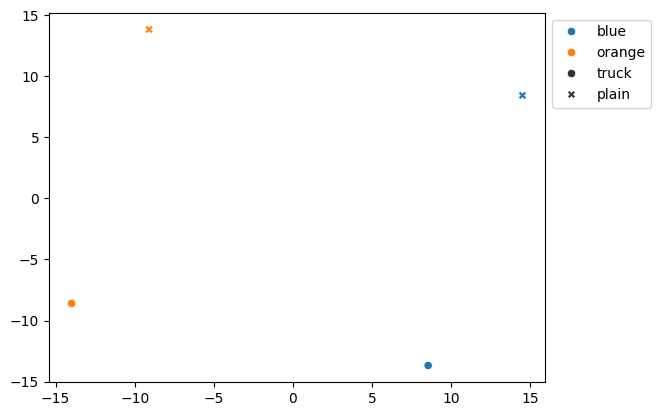

In [9]:
from utils import plot
plot.plot(projection, meta=data.descriptions)
#plot.plot(projection, meta=data.sentences)

# Interpolate Function

In [10]:
# interploate multidemensional vectors x,y in steps
from tqdm.notebook import tqdm_notebook as tqdm
def interpolate(x, y, steps):
    res = np.empty((steps,len(x)))
    for i in tqdm(range(len(x))):
        step = (y[i]-x[i])/(steps+1)
        for s in range(steps):
            res[s][i]= (x[i]+step*(s+1))
    return res

## Test interpolate

  0%|          | 0/2 [00:00<?, ?it/s]

<Axes: >

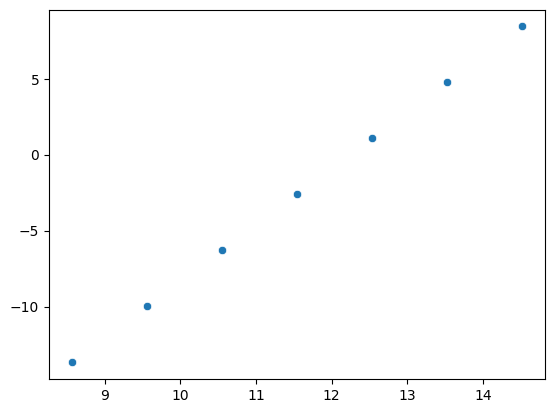

In [11]:
i=interpolate(projection[0], projection[1],5)

import seaborn as sns
a = [projection[0], projection[1]]
a = np.concatenate((a,i))
sns.scatterplot(x=a[:,0], y=a[:,1])

## Interpolate in pca space

  0%|          | 0/2 [00:00<?, ?it/s]

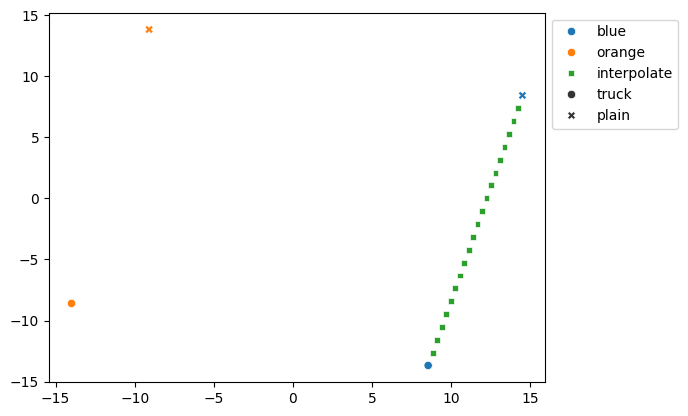

In [12]:
steps = 20
i = interpolate(projection[0], projection[1], steps)
da = np.concatenate((projection, i))
de = np.concatenate((data.descriptions,[['interpolate', 'interpolate', 'interpolate']]*steps))
plot.plot(da, meta=de)

## Interpolate in latent space

  0%|          | 0/768 [00:00<?, ?it/s]

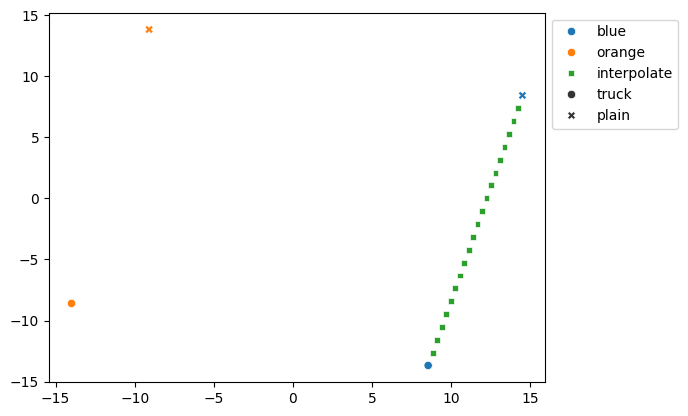

In [13]:
steps = 20
i = interpolate(embeddings[0], embeddings[1], steps)
i = pca.transform(i)
da = np.concatenate((projection, i))
de = np.concatenate((data.descriptions,[['interpolate', 'interpolate', 'interpolate']]*steps))
plot.plot(da, meta=de)